<a href="https://colab.research.google.com/github/MeenalShah13/SentimentAnalysisCOVID/blob/main/Final_AIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing of tweets

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
tweets=pd.read_csv('/content/gdrive/My Drive/covid19_tweets.csv')
tweets.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [ ]:
df = tweets

In [ ]:
df.shape

(179108, 13)

In [ ]:
df.isnull().sum() 

user_name               0
user_location       36771
user_description    10286
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            51334
source                 77
is_retweet              0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.duplicated().sum()

0

In [ ]:
df = df.drop_duplicates(subset=None, keep='first', inplace=False)

In [ ]:
df.isnull().sum()

user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
is_retweet          0
dtype: int64

In [ ]:
df.shape

(99138, 13)

## Sampling

In [ ]:
sample = df.sample(n=15000)
#sample.to_csv('sample_data.csv',index=False)

In [ ]:
sample.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
102650,FAO and the SDGs,"Rome, Italy",Working for a sustainable 🌍 and secure #Future...,2009-06-15 09:31:30,28039,6881,276,False,2020-08-11 10:17:02,"Now, more than ever, we need to adapt to &amp;...",['FAOResults'],Buffer,False
151412,OTV,"Bhubaneshwar, India",If something on Odisha is not on https://t.co/...,2011-12-16 07:28:52,549185,283,414,True,2020-08-18 17:09:24,#Odisha Chief Minister Naveen Patnaik asks off...,['Odisha'],Twitter Web App,False
112320,North Solihull Additional Needs Support Group,"Solihull, England",Support Group to empower parents with SEN kids...,2019-01-09 17:23:36,635,842,2553,False,2020-08-12 08:33:39,"Thank you CWSC for your kind donation, cards m...",['solihull'],Twitter for iPhone,False
87948,Easypolicy Insurance Web Aggregators Pvt. Ltd.,"Noida, India",You can get online quotes and calculate your #...,2011-02-08 07:32:44,1381,1127,61,False,2020-08-08 11:54:33,#IRDAI’s push for digitization makes buying #l...,"['IRDAI', 'life_insurance']",Twitter Web App,False
101861,The Conference Board of Canada,Canada,The Conference Board of Canada is the foremost...,2008-07-29 18:50:00,19043,2829,4718,False,2020-08-10 15:21:52,This year’s #pay planning cycle will no doubt ...,['pay'],Twitter Web App,False


In [ ]:
df1 = sample.drop(['user_created','user_description','user_followers','user_friends','user_favourites','user_verified','source','is_retweet'],axis=1)
df1.head()

,user_name,user_location,date,text,hashtags
102650,FAO and the SDGs,"Rome, Italy",2020-08-11 10:17:02,"Now, more than ever, we need to adapt to &amp;...",['FAOResults']
151412,OTV,"Bhubaneshwar, India",2020-08-18 17:09:24,#Odisha Chief Minister Naveen Patnaik asks off...,['Odisha']
112320,North Solihull Additional Needs Support Group,"Solihull, England",2020-08-12 08:33:39,"Thank you CWSC for your kind donation, cards m...",['solihull']
87948,Easypolicy Insurance Web Aggregators Pvt. Ltd.,"Noida, India",2020-08-08 11:54:33,#IRDAI’s push for digitization makes buying #l...,"['IRDAI', 'life_insurance']"
101861,The Conference Board of Canada,Canada,2020-08-10 15:21:52,This year’s #pay planning cycle will no doubt ...,['pay']


In [ ]:
df1['user_location'].value_counts()

India                             432
United States                     287
New Delhi, India                  194
Mumbai, India                     161
Washington, DC                    148
                                 ... 
Leigh On Sea                        1
Val-d'Oise, Ile-de-France           1
Middle of DOOMED usa #GodDidIt      1
Ground Work for Truth & Just        1
Madhuban Chowk Sec-14 Rohini        1
Name: user_location, Length: 5644, dtype: int64

In [ ]:
df1.shape

(15000, 5)

In [ ]:
df1.to_csv('sampledata.csv',index=False)

## Sentiment Polarity


In [ ]:
df1 = pd.read_csv("sampledata.csv")

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [ ]:
blanks = []  # start with an empty list

for i,un,ul,d,t,h in df1.itertuples():  # iterate over the DataFrame
    if type(t)==str:            # avoid NaN values
        if t.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list

df1.drop(blanks, inplace=True)
df1.shape

(15000, 5)

In [ ]:
df1['scores'] = df1['text'].apply(lambda review: sid.polarity_scores(review))

df1['compound']  = df1['scores'].apply(lambda score_dict: score_dict['compound'])


df1['label'] = df1['compound'].apply(lambda c: 'pos' if c >0 else ('neu' if c==0 else 'neg'))


df1.head()

,user_name,user_location,date,text,hashtags,scores,compound,label
0,FAO and the SDGs,"Rome, Italy",2020-08-11 10:17:02,"Now, more than ever, we need to adapt to &amp;...",['FAOResults'],"{'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'comp...",0.3182,pos
1,OTV,"Bhubaneshwar, India",2020-08-18 17:09:24,#Odisha Chief Minister Naveen Patnaik asks off...,['Odisha'],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu
2,North Solihull Additional Needs Support Group,"Solihull, England",2020-08-12 08:33:39,"Thank you CWSC for your kind donation, cards m...",['solihull'],"{'neg': 0.0, 'neu': 0.677, 'pos': 0.323, 'comp...",0.8225,pos
3,Easypolicy Insurance Web Aggregators Pvt. Ltd.,"Noida, India",2020-08-08 11:54:33,#IRDAI’s push for digitization makes buying #l...,"['IRDAI', 'life_insurance']","{'neg': 0.0, 'neu': 0.797, 'pos': 0.203, 'comp...",0.4215,pos
4,The Conference Board of Canada,Canada,2020-08-10 15:21:52,This year’s #pay planning cycle will no doubt ...,['pay'],"{'neg': 0.211, 'neu': 0.717, 'pos': 0.072, 'co...",-0.4767,neg


In [ ]:
df1.to_csv('finalsample.csv',index=False)

In [ ]:
df1['label'].value_counts()

pos    5597
neu    5543
neg    3860
Name: label, dtype: int64

## Contractions removal

In [ ]:
import re
contractions_dict = {"can`t":"can not",
                     "won`t":"will not",
                     "don`t":"do not",
                     "aren`t":"are not",
                     "i`d":"i would",
                     "couldn`t": "could not",
                     "shouldn`t": "should not",
                     "wouldn`t": "would not",
                     "isn`t": "is not",
                     "it`s": "it is",
                     "didn`t": "did not",
                     "weren`t": "were not",
                     "mustn`t": "must not",
                    }

def prepare_data(df1:pd.DataFrame) -> pd.DataFrame:
    
    df1["text"] = df1["text"] \
              .apply(lambda x: re.split('http:\/\/.*', str(x))[0]) \
              .str.lower() \
              .apply(lambda x: replace_words(x,contractions_dict))
        
    df1["label"] = df1["label"].map(
                        {"neu": 1, "neg":0, "pos":2 }
                        )
    return df1.text.values, df1.label.values
def replace_words(string:str, dictionary:dict):
    for k, v in dictionary.items():
        string = string.replace(k, v)
    return string


##Lowercasing, Removing stopwords, and lemmatization

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"

for words in range(len(df1["text"])):
  word_tokens = word_tokenize(df1["text"][words].lower())
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  filtered_sentence = []
  for w in word_tokens:
    if w not in stop_words and w not in symbols:
      filtered_sentence.append(lemmatizer.lemmatize(w))
  df1["text"][words] = " ".join(filtered_sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Word Cloud Generation

In [ ]:
import matplotlib.pyplot as plt 

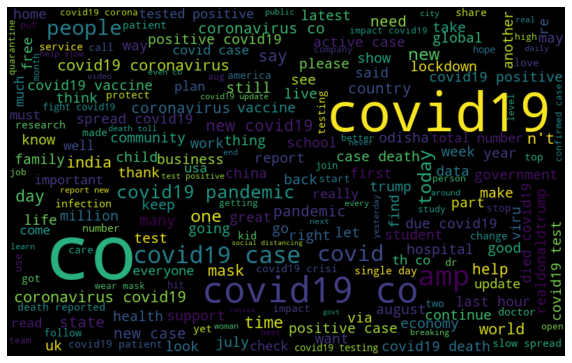

In [ ]:
# create text from all tweets
all_words = ' '.join(df1['text'].tolist())

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

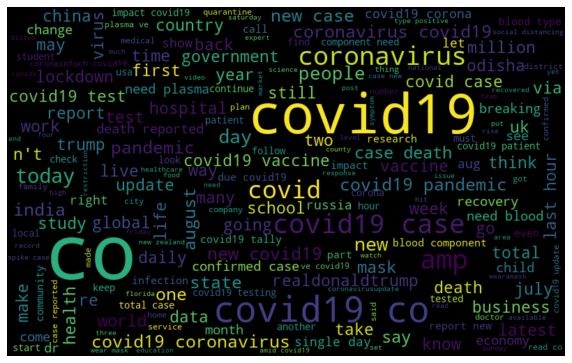

In [ ]:
# create text from just normal tweets
df_1 = df1[df1['label']=="neu"]
normal_words = ' '.join(df_1['text'].tolist())

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

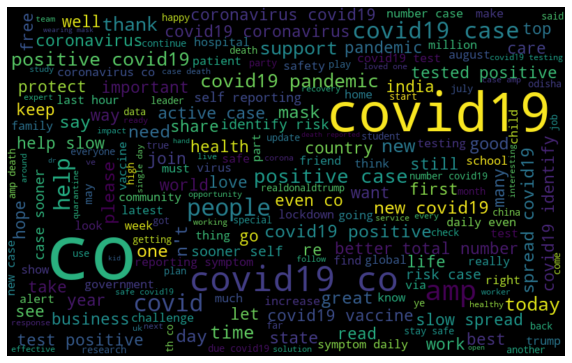

In [ ]:
# create text from just positive tweets
df_1 = df1[df1['label']=="pos"]
pos_words = ' '.join(df_1['text'].tolist())

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

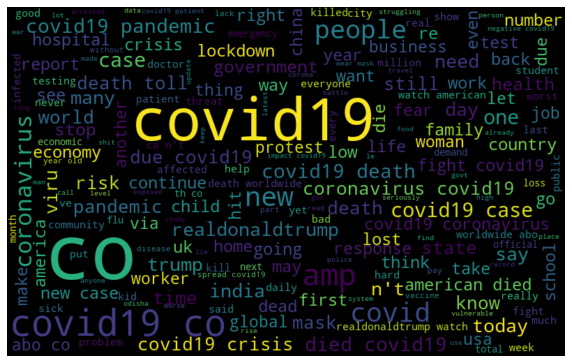

In [ ]:
# create text from just negative tweets
df_1 = df1[df1['label']=="neg"]
neg_words = ' '.join(df_1['text'].tolist())

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Random forest classifier

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

X = df1.text
Y =df1.label

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



X_train = X_train \
              .apply(lambda x: re.split('http:\/\/.*', str(x))[0]) \
              .str.lower() \
              .apply(lambda x: replace_words(x,contractions_dict))

X_test = X_test \
              .apply(lambda x: re.split('http:\/\/.*', str(x))[0]) \
              .str.lower() \
              .apply(lambda x: replace_words(x,contractions_dict))

y_train =  y_train.map(
                        {"neu": 1, "neg":0, "pos":2 }
                        )
y_test = y_test.map(
                        {"neu": 1, "neg":0, "pos":2 }
                        )


(12000,) (12000,)
(3000,) (3000,)


In [ ]:
train_tweets, train_labels = X_train,y_train
test_tweets, test_labels = X_test,y_test

In [ ]:
pip install keras


_______________________________________

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweets)
train_tokenized = tokenizer.texts_to_matrix(
                             train_tweets,
                             mode='tfidf'
                             )
test_tokenized = tokenizer.texts_to_matrix(
                             test_tweets,
                             mode='tfidf'
                             )

In [ ]:
from  sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(
                                n_estimators=500, 
                                min_samples_leaf=2,
                                oob_score=True,
                                n_jobs=-1,
                                )
forest.fit(train_tokenized,train_labels)
print(f"Train score: {forest.score(train_tokenized,train_labels)}")
print(f"OOB score: {forest.oob_score_}")

Train score: 0.84425
OOB score: 0.7660833333333333


In [ ]:
print("Test score:", forest.score(test_tokenized,test_labels))

Test score: 0.753
